Seeds used: [51, 592, 1014, 1571, 2060, 2520, 3082, 3586, 4074, 4574, 5087, 5599, 6023, 6502, 7021, 7552, 8001, 8587, 9029, 9537]

[Stable Red Points] (occurrence ≥ 1)
eig_idx  count
   eig0     20
   eig1     20

[Stable Orange Points] (occurrence ≥ 1)
No stable points found

[Stable Green Points] (occurrence ≥ 1)
eig_idx  count
eig1003      2
eig3643      1
eig1549      1
 eig926      1
eig3763      1
eig3557      1
eig4030      1
eig3679      1
eig1656      1
eig1473      1
eig1014      1
eig1775      1
eig1512      1
eig1434      1
 eig954      1
 eig673      1
eig3672      1
eig1237      1
eig1657      1
eig3957      1
eig1798      1
eig3821      1
eig3883      1
 eig579      1
 eig914      1
eig1251      1
eig1264      1
eig1585      1
eig3863      1
eig3864      1
 eig999      1
eig1419      1
eig1974      1
eig3742      1
eig3346      1
eig3956      1
eig3674      1
eig3835      1
eig1255      1
eig1645      1
eig3922      1
eig4032      1
eig1286      1
eig1617      1
eig3798 

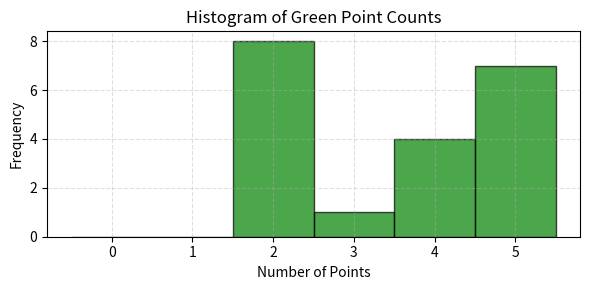

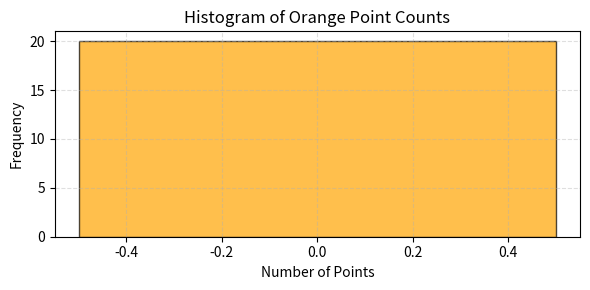

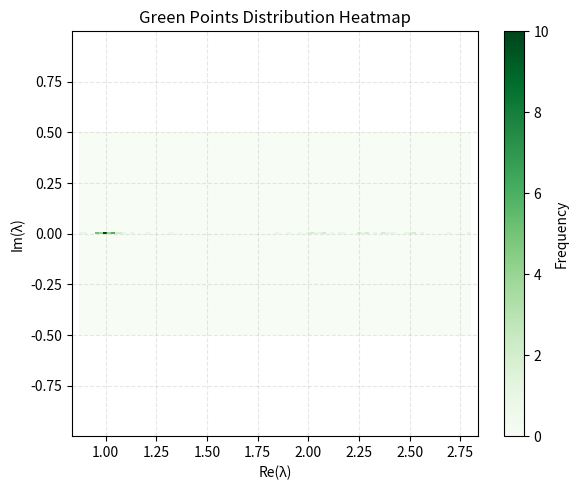


[Standard 1] Cross-trial recurrence of green points (Top 20):
 Re_q  Im_q  count
0.995   0.0      5
0.955   0.0      4
1.005   0.0      3
1.025   0.0      3
0.980   0.0      3
1.015   0.0      2
2.010   0.0      2
1.040   0.0      2
0.990   0.0      2
1.000   0.0      2
2.365   0.0      1
2.075   0.0      1
1.080   0.0      1
1.050   0.0      1
2.510   0.0      1
1.965   0.0      1
2.260   0.0      1
1.905   0.0      1
2.060   0.0      1
2.155   0.0      1
[Standard 1] Fixed-point existence? False

[Standard 2] Number of trials with ≥2 green points in region A [0.95, 1.05]: 12/20, ratio=0.60

[Standard 3] Per-trial counts of green points in regions A and B:
 seed  A_count  B_count
   51        2        0
  592        2        0
 1014        2        0
 1571        2        0
 2060        2        0
 2520        1        0
 3082        2        0
 3586        2        0
 4074        1        0
 4574        2        0
 5087        2        0
 5599        1        0
 6023        0       

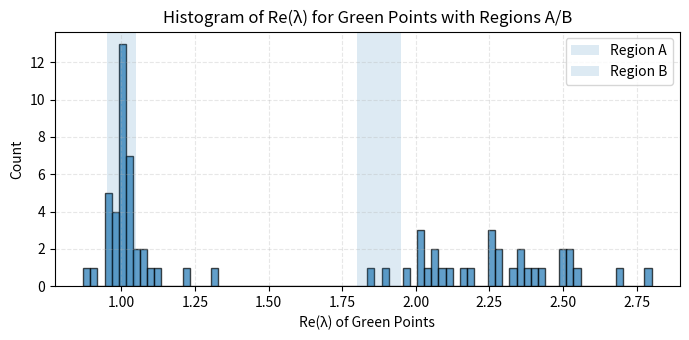

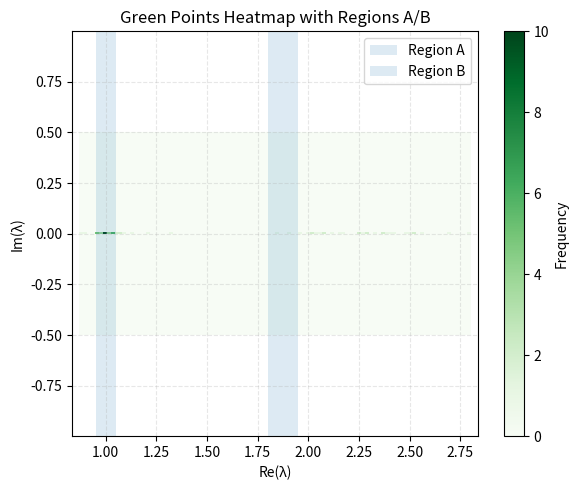


========== Stability Evaluation Summary ==========
Standard 1: Grid-based recurrence statistics show no absolutely fixed green points.
Standard 2: Region A [0.95, 1.05] has ≥2 green points in 12/20 trials (ratio 0.60).
Standard 3: Region A tends to be more stable; suggested seeds for subspace recovery are listed above.


In [1]:
# ==================================================
# ASE: Stability Evaluation of Green Eigenvalues (Multi-Seed)
#
# Three evaluation standards:
#   Standard 1: Cross-trial recurrence of the same grid point (fixed-point hypothesis)
#   Standard 2: Whether ≥2 green points appear in region A [A_min, A_max] per trial
#   Standard 3: Counts of green points in regions A and B per trial, suggesting seeds for subspace recovery
# ==================================================

import numpy as np
import torch
import pandas as pd
from scipy.special import kv as besselk
from scipy.stats import gaussian_kde
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 0) Parameters
n, p, alpha, alpha_c = 5000, 2, 5, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
delta = 0.15         # Offset for KDE-based density jump
jump_margin = 0.1    # Additional margin beyond jump threshold

num_trials = 20
np.random.seed(42)
base_seeds = np.arange(0, 10000, step=500)[:num_trials]
noise = np.random.randint(0, 100, size=num_trials)
seeds = (base_seeds + noise).tolist()
print("Seeds used:", seeds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Counters and recorders
red_counter = defaultdict(int)
orange_counter = defaultdict(int)
green_counter = defaultdict(int)

green_count_list = []     # Number of green points per trial
orange_count_list = []    # Number of orange points per trial
green_coords = []         # Record coordinates of green points (Re, Im)

# 2) Single trial function 
def run_single_trial(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Generate data
    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    # Construct G(y)
    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    # Construct spectral matrix L
    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    # Eigenvalue computation
    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.detach().cpu().numpy().astype(np.complex128)

    eig_df = pd.DataFrame({
        "eig_idx": [f"eig{i}" for i in range(len(eigvals_np))],
        "eigval": eigvals_np,
        "Re": eigvals_np.real,
        "Im": eigvals_np.imag,
        "Abs": np.abs(eigvals_np)
    })

    # Red points: top-2 by largest real part
    red_pts = eig_df.sort_values(by="Re", ascending=False).head(2)
    for idx in red_pts["eig_idx"]:
        red_counter[idx] += 1

    # Orange points: Re > alpha/alpha_c, excluding red points
    orange_mask = (eig_df["Re"] > thresh_ext) & (~eig_df["eig_idx"].isin(red_pts["eig_idx"]))
    orange_pts = eig_df[orange_mask]
    for idx in orange_pts["eig_idx"]:
        orange_counter[idx] += 1

    # Green points: based on KDE peak and right jump threshold, |λ| < R, Re > jump threshold
    real_axis_re = eig_df.loc[np.abs(eig_df["Im"]) < 1e-6, "Re"].values
    if len(real_axis_re) >= 100:
        kde = gaussian_kde(real_axis_re)
        grid = np.linspace(np.min(real_axis_re), np.max(real_axis_re), 1024)
        density = kde(grid)
        pileup_center = grid[np.argmax(density)]
        jump_thresh = pileup_center + delta

        green_mask = (
            (np.abs(eig_df["Im"]) < 1e-6) &
            (eig_df["Abs"] < R) &
            (eig_df["Re"] > jump_thresh + jump_margin)
        )
        green_pts = eig_df[green_mask].sort_values(by="Re", ascending=False).head(5)
    else:
        green_pts = eig_df.iloc[[]]

    for idx in green_pts["eig_idx"]:
        green_counter[idx] += 1

    green_count_list.append(len(green_pts))
    orange_count_list.append(len(orange_pts))

    # Record green point coordinates
    for _, row in green_pts.iterrows():
        green_coords.append((row["Re"], row["Im"]))

# 3) Run multiple trials
for seed in seeds:
    run_single_trial(seed)

# 4) Display stable points above threshold
def display_stable_points(counter_dict, label, threshold=1):
    filtered = [(k, v) for k, v in counter_dict.items() if v >= threshold]
    df = pd.DataFrame(filtered, columns=["eig_idx", "count"]).sort_values(by="count", ascending=False)
    print(f"\n[Stable {label} Points] (occurrence ≥ {threshold})")
    print(df.to_string(index=False) if not df.empty else "No stable points found")

display_stable_points(red_counter, "Red", threshold=1)
display_stable_points(orange_counter, "Orange", threshold=1)
display_stable_points(green_counter, "Green", threshold=1)

# 5) Histogram of green/orange counts per trial
green_series = pd.Series(green_count_list, name="GreenCount")
orange_series = pd.Series(orange_count_list, name="OrangeCount")

print("\n[Histogram of Green Point Counts]")
print(green_series.value_counts().sort_index().to_string())
print("\n[Histogram of Orange Point Counts]")
print(orange_series.value_counts().sort_index().to_string())

def plot_histogram(counts, title, color):
    plt.figure(figsize=(6, 3))
    plt.hist(counts, bins=np.arange(-0.5, max(counts) + 1.5, 1),
             edgecolor='black', alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel("Number of Points")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_histogram(green_count_list, "Histogram of Green Point Counts", "green")
plot_histogram(orange_count_list, "Histogram of Orange Point Counts", "orange")

# 6) Green point coordinate heatmap
def plot_green_point_heatmap(coords, bins=100):
    coords_np = np.array(coords)
    if coords_np.size == 0:
        print("No green points to plot")
        return
    x, y = coords_np[:, 0], coords_np[:, 1]
    plt.figure(figsize=(6, 5))
    plt.hist2d(x, y, bins=bins, cmap='Greens')
    plt.colorbar(label='Frequency')
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("Green Points Distribution Heatmap")
    plt.axis("equal")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_green_point_heatmap(green_coords)

# 7) Stability evaluation using three standards
real_tol = 1e-6
bin_width_re = 0.005
bin_width_im = 0.005

# Define regions A and B
A_min, A_max = 0.95, 1.05
B_min, B_max = 1.80, 1.95

# Helper: quantize coordinates (for standard 1)
def quantize_coord(x, w): return np.round(x / w) * w
def bucketize_point(re, im, w_re, w_im): return (quantize_coord(re, w_re), quantize_coord(im, w_im))

# Standard 1: cross-trial recurrence of the same grid point
green_bucket_counter = Counter()
for (re, im) in green_coords:
    key = bucketize_point(re, im, bin_width_re, bin_width_im)
    green_bucket_counter[key] += 1

bucket_df = pd.DataFrame(
    [{"Re_q": re_q, "Im_q": im_q, "count": cnt}
     for (re_q, im_q), cnt in green_bucket_counter.items()]
).sort_values("count", ascending=False)

print("\n[Standard 1] Cross-trial recurrence of green points (Top 20):")
print(bucket_df.head(20).to_string(index=False) if not bucket_df.empty else "No green points to analyze")

fixed_like_exists = (not bucket_df.empty) and (bucket_df["count"].max() >= num_trials * 0.8)
print(f"[Standard 1] Fixed-point existence? {fixed_like_exists}")

# Standard 2 and 3: per-trial statistics of green points in regions A and B
trial_slices, start = [], 0
for k in range(num_trials):
    cnt = green_count_list[k]
    trial_slices.append((start, start + cnt))
    start += cnt

A_ge2 = 0
A_ge2_seeds = []
per_trial_counts = []
regionA_coords_all, regionB_coords_all = [], []

for k, (lo, hi) in enumerate(trial_slices):
    seed_k = seeds[k]
    coords_k = green_coords[lo:hi]
    Ak = [(re, im) for (re, im) in coords_k if (abs(im) < real_tol and (A_min <= re <= A_max))]
    Bk = [(re, im) for (re, im) in coords_k if (abs(im) < real_tol and (B_min <= re <= B_max))]

    per_trial_counts.append({"seed": seed_k, "A_count": len(Ak), "B_count": len(Bk),
                             "A_coords": Ak, "B_coords": Bk})
    regionA_coords_all.extend(Ak)
    regionB_coords_all.extend(Bk)

    if len(Ak) >= 2:
        A_ge2 += 1
        A_ge2_seeds.append(seed_k)

ratio_A_ge2 = A_ge2 / num_trials
print(f"\n[Standard 2] Number of trials with ≥2 green points in region A [{A_min}, {A_max}]: "
      f"{A_ge2}/{num_trials}, ratio={ratio_A_ge2:.2f}")

per_trial_df = pd.DataFrame(per_trial_counts)
print("\n[Standard 3] Per-trial counts of green points in regions A and B:")
print(per_trial_df[["seed", "A_count", "B_count"]].to_string(index=False))

if len(A_ge2_seeds) > 0:
    print("\n[Standard 3] Seeds suitable for subspace recovery evaluation:")
    print(A_ge2_seeds)
else:
    print("\n[Standard 3] No trials satisfy ≥2 green points in region A.")

# 8) Visualization of green point distributions
# (a) Histogram of Re(λ) with region A/B bands
re_all = np.array([c[0] for c in green_coords]) if len(green_coords) > 0 else np.array([])
if re_all.size > 0:
    plt.figure(figsize=(7, 3.5))
    plt.hist(re_all, bins=80, edgecolor='black', alpha=0.7, density=False)
    plt.axvspan(A_min, A_max, alpha=0.15, label='Region A')
    plt.axvspan(B_min, B_max, alpha=0.15, label='Region B')
    plt.xlabel("Re(λ) of Green Points")
    plt.ylabel("Count")
    plt.title("Histogram of Re(λ) for Green Points with Regions A/B")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No green points, skipping Re(λ) histogram.")

# (b) 2D heatmap with region A/B boundaries
def plot_green_point_heatmap_with_bands(coords, bins=100):
    coords_np = np.array(coords)
    if coords_np.size == 0:
        print("No green points to plot")
        return
    x, y = coords_np[:, 0], coords_np[:, 1]
    plt.figure(figsize=(6, 5))
    plt.hist2d(x, y, bins=bins, cmap='Greens')
    plt.colorbar(label='Frequency')
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("Green Points Heatmap with Regions A/B")
    plt.axvspan(A_min, A_max, alpha=0.15, label='Region A')
    plt.axvspan(B_min, B_max, alpha=0.15, label='Region B')
    plt.axis("equal")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_green_point_heatmap_with_bands(green_coords)

# 9) Summary
print("\n========== Stability Evaluation Summary ==========")
print("Standard 1: Grid-based recurrence statistics show no absolutely fixed green points.")
print(f"Standard 2: Region A [{A_min}, {A_max}] has ≥2 green points in {A_ge2}/{num_trials} trials "
      f"(ratio {ratio_A_ge2:.2f}).")
print("Standard 3: Region A tends to be more stable; suggested seeds for subspace recovery are listed above.")
